Recruit Restaurant Visitorで、   
・自分のGridSearchによるHyperParameter探索   
・Hyperoptを使ったHyperParameter探索   
の２つを探索する    

Ver1:  
・探索するハイパーパラメータについて、  
・大局的に良さそうなところを見つけて、この周辺を細かく探索する２段階で行う

整数型の扱いについては以下の記事を参考にした  
[Hyperparameters tunning with Hyperopt](https://www.kaggle.com/ilialar/hyperparameters-tunning-with-hyperopt)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

import pickle

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score

import lightgbm as lgb
#import optuna.integration.lightgbm as lgbo

plt.style.use('ggplot')

In [3]:
from hyperopt import hp, tpe, Trials, fmin

シンプルにモデルを作ることに焦点を絞るため、air_visit_dataだけを使う

In [4]:
df_air_visit_data = pd.read_csv('./raw_data/air_visit_data.csv/air_visit_data.csv')
df_air_visit_data

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


In [5]:
df_air_visit_data['visit_date'] = df_air_visit_data['visit_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

曜日の情報は必要となるのでdf_date_infoも読み込む

In [6]:
df_date_info = pd.read_csv('./raw_data/date_info.csv/date_info.csv')

In [7]:
df_date_info

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [8]:
df_date_info['calendar_date'] = df_date_info['calendar_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

ユーザー数の増加に影響されずに人数を予測するため、平均値を求める

In [9]:
df_air_visit_mean = df_air_visit_data.groupby('visit_date', as_index=False).mean()
df_air_visit_mean.head()

,visit_date,visitors
0,2016-01-01,21.520833
1,2016-01-02,28.000000
2,2016-01-03,29.234568
3,2016-01-04,21.184713
4,2016-01-05,17.000000


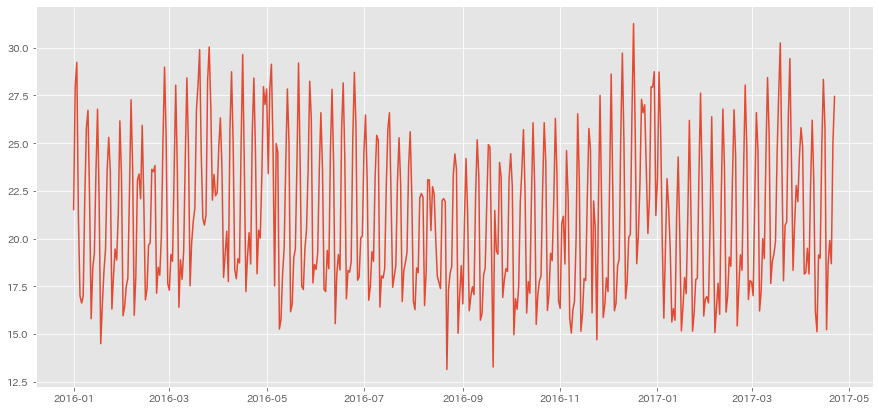

In [10]:
plt.figure(figsize=(15,7))
plt.plot(df_air_visit_mean['visit_date'], df_air_visit_mean['visitors'])

In [11]:
df_air_visit_mean = pd.merge(df_air_visit_mean, df_date_info.rename(columns={'calendar_date':'visit_date'}),\
                                  how='inner', on='visit_date')

In [12]:
df_air_visit_mean.head()

,visit_date,visitors,day_of_week,holiday_flg
0,2016-01-01,21.520833,Friday,1
1,2016-01-02,28.000000,Saturday,1
2,2016-01-03,29.234568,Sunday,1
3,2016-01-04,21.184713,Monday,0
4,2016-01-05,17.000000,Tuesday,0


## 学習データ作成

In [13]:
df_air_visit_mean['prev_holiday_flg'] = df_air_visit_mean['holiday_flg'].shift(-1).fillna(0)

In [14]:
df_air_visit_mean['prev_holiday_flg'].value_counts()

0.0    448
1.0     30
Name: prev_holiday_flg, dtype: int64

In [15]:
df_air_visit_mean['holiday_flg'].value_counts()

0    447
1     31
Name: holiday_flg, dtype: int64

In [16]:
df_air_visit_mean_dummy = pd.get_dummies(df_air_visit_mean, columns=['day_of_week'])

In [17]:
df_air_visit_mean_dummy.head()

,visit_date,visitors,holiday_flg,prev_holiday_flg,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2016-01-01,21.520833,1,1.0,1,0,0,0,0,0,0
1,2016-01-02,28.000000,1,1.0,0,0,1,0,0,0,0
2,2016-01-03,29.234568,1,0.0,0,0,0,1,0,0,0
3,2016-01-04,21.184713,0,0.0,0,1,0,0,0,0,0
4,2016-01-05,17.000000,0,0.0,0,0,0,0,0,1,0


In [18]:
X = df_air_visit_mean_dummy.drop(['visit_date', 'visitors'], axis=1)
X

,holiday_flg,prev_holiday_flg,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,1,1.0,1,0,0,0,0,0,0
1,1,1.0,0,0,1,0,0,0,0
2,1,0.0,0,0,0,1,0,0,0
3,0,0.0,0,1,0,0,0,0,0
4,0,0.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
473,0,0.0,0,0,0,0,0,1,0
474,0,0.0,0,0,0,0,0,0,1
475,0,0.0,0,0,0,0,1,0,0
476,0,0.0,1,0,0,0,0,0,0


In [19]:
var_list = X.columns.tolist()
var_list

['holiday_flg',
 'prev_holiday_flg',
 'day_of_week_Friday',
 'day_of_week_Monday',
 'day_of_week_Saturday',
 'day_of_week_Sunday',
 'day_of_week_Thursday',
 'day_of_week_Tuesday',
 'day_of_week_Wednesday']

In [20]:
y = df_air_visit_mean_dummy['visitors']
y

0      21.520833
1      28.000000
2      29.234568
3      21.184713
4      17.000000
         ...    
473    18.656985
474    19.900545
475    18.678238
476    25.030612
477    27.448320
Name: visitors, Length: 478, dtype: float64

In [21]:
X.shape[0]

478

In [22]:
num_train = int(X.shape[0]*0.8)
print('number of train', num_train)

number of train 382


In [23]:
X_train = X[:num_train]
X_test = X[num_train:]
print('shape of X_train', X_train.shape)
print('shape of X_test ', X_test.shape)

shape of X_train (382, 9)
shape of X_test  (96, 9)


In [24]:
y_train = y[:num_train]
y_test = y[num_train:]
print(y_train.shape)
print(y_test.shape)

(382,)
(96,)


# Time series cross validation と GridSearcCVでLightGBMモデルを作成

In [25]:
tscv = TimeSeriesSplit()
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [26]:
tscv.split(X_train, y_train)

<generator object TimeSeriesSplit.split at 0x000002247663DCC8>

In [27]:
train_index_list = []
val_index_list = []
for train_index, val_index in tscv.split(X_train, y_train):
    print('train:',len(train_index), ' validation:', len(val_index))
    train_index_list.append(train_index)
    val_index_list.append(val_index)

train: 67  validation: 63
train: 130  validation: 63
train: 193  validation: 63
train: 256  validation: 63
train: 319  validation: 63


In [28]:
val_index_list

[array([ 67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]),
 array([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192]),
 array([193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
        219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
        232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,

In [29]:

param_grid1 = {
    'num_leaves':[5,10,20,30,40],
    'max_depth':[5,10,15,20],
    'n_estimators':[10,25,50,100,200],
    'reg_lambda':[0, 0.001, 0.01, 0.1, 1]
    
}

In [30]:
lgb_estimator = lgb.LGBMRegressor(random_state=0)

In [31]:
gsearch1 = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid1, cv=tscv, scoring = 'neg_root_mean_squared_error')

In [32]:
%%time
lgb_model1 = gsearch1.fit(X=X_train, y=y_train)

Wall time: 1min 39s


In [33]:
lgb_model1.best_params_

{'max_depth': 5, 'n_estimators': 25, 'num_leaves': 10, 'reg_lambda': 0.1}

In [34]:
param_grid2 = {
    'num_leaves':[7,8,9,10,11,12,13,14],
    'max_depth':[7,8,9,10,11,12,13],
    'n_estimators':[30,40,50,60,70],
    'reg_lambda':[0,0.005,0.0075,0.01,0.02,0.003,0.005]
    
}

In [35]:
gsearch2 = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid2, cv=tscv, scoring = 'neg_root_mean_squared_error')

In [36]:
%%time
lgb_model2 = gsearch2.fit(X=X_train, y=y_train)

Wall time: 5min 23s


In [37]:
lgb_model2.best_params_

{'max_depth': 7, 'n_estimators': 30, 'num_leaves': 8, 'reg_lambda': 0.01}

In [38]:
df_lgb_model_results = pd.DataFrame(lgb_model2.cv_results_)
df_lgb_model_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
605,0.018000,0.005098,0.004998,0.000004,9,30,13,0.01,"{'max_depth': 9, 'n_estimators': 30, 'num_leav...",-4.387107,-3.989243,-2.321313,-2.095944,-3.018619,-3.162445,0.899889,1
304,0.022001,0.005998,0.004999,0.000003,8,30,10,0.01,"{'max_depth': 8, 'n_estimators': 30, 'num_leav...",-4.387107,-3.989243,-2.321313,-2.095944,-3.018619,-3.162445,0.899889,1
1438,0.015999,0.004898,0.005000,0.000001,12,30,12,0.01,"{'max_depth': 12, 'n_estimators': 30, 'num_lea...",-4.387107,-3.989243,-2.321313,-2.095944,-3.018619,-3.162445,0.899889,1
871,0.018001,0.006782,0.004998,0.000003,10,30,11,0.01,"{'max_depth': 10, 'n_estimators': 30, 'num_lea...",-4.387107,-3.989243,-2.321313,-2.095944,-3.018619,-3.162445,0.899889,1
31,0.021000,0.007347,0.005000,0.003163,7,30,11,0.01,"{'max_depth': 7, 'n_estimators': 30, 'num_leav...",-4.387107,-3.989243,-2.321313,-2.095944,-3.018619,-3.162445,0.899889,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.034001,0.015622,0.004999,0.000003,8,70,7,0.02,"{'max_depth': 8, 'n_estimators': 70, 'num_leav...",-4.387107,-3.989243,-2.357692,-2.097848,-3.015398,-3.169458,0.892834,1954
1628,0.024002,0.011575,0.005000,0.000002,12,70,7,0.02,"{'max_depth': 12, 'n_estimators': 70, 'num_lea...",-4.387107,-3.989243,-2.357692,-2.097848,-3.015398,-3.169458,0.892834,1954
788,0.028000,0.012885,0.004999,0.000002,9,70,7,0.02,"{'max_depth': 9, 'n_estimators': 70, 'num_leav...",-4.387107,-3.989243,-2.357692,-2.097848,-3.015398,-3.169458,0.892834,1954
1908,0.042003,0.020153,0.004997,0.000011,13,70,7,0.02,"{'max_depth': 13, 'n_estimators': 70, 'num_lea...",-4.387107,-3.989243,-2.357692,-2.097848,-3.015398,-3.169458,0.892834,1954


In [39]:
np.sqrt( mean_squared_error(y_test,lgb_model2.predict(X_test) ) )

1.5863437047685356

In [40]:
#モデル式の保存
pickle.dump(lgb_model2, open('gscv_lgbm_model.pkl','wb'))

# hyperoptを使ってパラメータチューニング

In [41]:
params_hyperopt1 = {
    'num_leaves':hp.quniform('num_leaves',5,40,2),
    'max_depth':hp.quniform('max_depth',5,20,2),
    'n_estimators':hp.quniform('n_estimators',10,200,10),
    'reg_lambda':hp.loguniform('reg_lambda', np.log(0.001), np.log(1))
}

In [42]:
def objective(args):
    args = {
        'num_leaves':int(args['num_leaves']),
        'max_depth':int(args['max_depth']),
        'n_estimators':int(args['n_estimators']),
        'reg_lambda':args['reg_lambda']
        
    }
    
    lgb_hyp = lgb.LGBMRegressor(**args, random_state=0)
    
    score_array = cross_val_score(estimator=lgb_hyp, X=X_train, y=y_train, cv=tscv, scoring = 'neg_root_mean_squared_error')
    score_mean = np.mean(score_array)
    
    return -1*score_mean
    
    

In [43]:
# iterationする回数
max_evals = 2000
# 試行の過程を記録するインスタンス
trials1 = Trials()

In [44]:
%%time
best1 = fmin(
    # 最小化する値を定義した関数
    objective,
    # 探索するパラメータのdictもしくはlist
    space=params_hyperopt1,
    # どのロジックを利用するか、基本的にはtpe.suggestでok
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials1,
    # 試行の過程を出力
    verbose=1,
    # 結果再現のため乱数を固定
    rstate=np.random.RandomState(0)
)

100%|████████████████████████████████████████████| 2000/2000 [12:09<00:00,  2.74trial/s, best loss: 3.1614388482694884]
Wall time: 12min 9s


In [45]:
best1 = {
    'num_leaves':int(best1['num_leaves']),
    'max_depth':int(best1['max_depth']),
    'reg_lambda':best1['reg_lambda'],
    'n_estimators':int(best1['n_estimators'])
    
}
best1

{'num_leaves': 36,
 'max_depth': 14,
 'reg_lambda': 0.9067818858763805,
 'n_estimators': 30}

In [46]:
trials1.results

[{'loss': 3.1699779730560445, 'status': 'ok'},
 {'loss': 3.169648946988976, 'status': 'ok'},
 {'loss': 3.1698471323903545, 'status': 'ok'},
 {'loss': 3.169475817355864, 'status': 'ok'},
 {'loss': 3.1695284382274074, 'status': 'ok'},
 {'loss': 3.169706430061881, 'status': 'ok'},
 {'loss': 3.1696532045196686, 'status': 'ok'},
 {'loss': 3.1692306776985775, 'status': 'ok'},
 {'loss': 3.1698332151627815, 'status': 'ok'},
 {'loss': 3.169764178506111, 'status': 'ok'},
 {'loss': 3.16913128837571, 'status': 'ok'},
 {'loss': 3.166634101983417, 'status': 'ok'},
 {'loss': 3.1701429296638035, 'status': 'ok'},
 {'loss': 3.169850235858612, 'status': 'ok'},
 {'loss': 3.1701092868342817, 'status': 'ok'},
 {'loss': 3.169621988139817, 'status': 'ok'},
 {'loss': 3.3078871885286487, 'status': 'ok'},
 {'loss': 3.1666673841624555, 'status': 'ok'},
 {'loss': 3.1663328479033885, 'status': 'ok'},
 {'loss': 3.1691513222284184, 'status': 'ok'},
 {'loss': 3.1624449476686194, 'status': 'ok'},
 {'loss': 3.1663315650

In [47]:
for item in trials1.trials:
    vals = item['misc']['vals']
    print(vals)

{'max_depth': [8.0], 'n_estimators': [200.0], 'num_leaves': [28.0], 'reg_lambda': [0.028717191816925735]}
{'max_depth': [14.0], 'n_estimators': [130.0], 'num_leaves': [28.0], 'reg_lambda': [0.03916449174261763]}
{'max_depth': [14.0], 'n_estimators': [180.0], 'num_leaves': [40.0], 'reg_lambda': [0.005958198748137256]}
{'max_depth': [8.0], 'n_estimators': [80.0], 'num_leaves': [8.0], 'reg_lambda': [0.03855451340006999]}
{'max_depth': [12.0], 'n_estimators': [100.0], 'num_leaves': [32.0], 'reg_lambda': [0.002768595035796019]}
{'max_depth': [10.0], 'n_estimators': [150.0], 'num_leaves': [14.0], 'reg_lambda': [0.004983587463782142]}
{'max_depth': [12.0], 'n_estimators': [150.0], 'num_leaves': [40.0], 'reg_lambda': [0.3269634051397779]}
{'max_depth': [8.0], 'n_estimators': [90.0], 'num_leaves': [32.0], 'reg_lambda': [0.7968813716914994]}
{'max_depth': [6.0], 'n_estimators': [150.0], 'num_leaves': [24.0], 'reg_lambda': [0.03399907795438784]}
{'max_depth': [20.0], 'n_estimators': [160.0], 'num

In [48]:
lgbm_hyp_best1 = lgb.LGBMRegressor(**best1, random_state=0)
lgbm_hyp_best1

LGBMRegressor(max_depth=14, n_estimators=30, num_leaves=36, random_state=0,
              reg_lambda=0.9067818858763805)

In [49]:
lgbm_hyp_best1.fit(X_train, y_train)
print( np.sqrt(mean_squared_error(y_test, lgbm_hyp_best1.predict(X_test))) )

1.5923797093822105


In [50]:
#モデル式の保存
pickle.dump(lgbm_hyp_best1, open('hyperopt_lgbm_model.pkl', 'wb'))